In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=True)
numSamples = len(train_dataset)                   

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz


# Dataset

### Prepare raw dataset and empirical second moments

In [2]:
# Prepare data tensors
def _get_tensor(ds, n):
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t)
    return torch.stack(imgs).to(device)

X_raw = _get_tensor(train_dataset, numSamples)
dim = X_raw[0].numel()
r = 25

X = X_raw.view(numSamples, -1).T
gammaX = (1/numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)

### Construct blurred observation using the median filter

In [3]:
import torch.nn.functional as F

def median_blur(x, k=5):
    # Handle grayscale: (H, W) → (1, H, W)
    if x.ndim == 2:
        x_in = x.unsqueeze(0)      # make channel dim
    elif x.ndim == 3:
        x_in = x                   # already (C, H, W)
    else:
        raise ValueError("Input must be (H,W) or (C,H,W).")

    C, H, W = x_in.shape
    out = torch.zeros_like(x_in)

    for c in range(C):
        patches = F.unfold(
            x_in[c].unsqueeze(0).unsqueeze(0),
            kernel_size=k,
            padding=k // 2
        )
        med = patches.median(dim=1).values
        out[c] = med.view(H, W)

    # Return to original shape
    return out if x.ndim == 3 else out.squeeze(0)



Y_list = []
for i in range(numSamples):
    Y_list.append(median_blur(X_raw[i], k=5))
Y_raw = torch.stack(Y_list)
Y = Y_raw.view(numSamples, -1).T

noiseSigma = 0.05
E = torch.randn_like(Y) * noiseSigma
Y_noisy = Y + E
gammaE = noiseSigma**2 * torch.eye(dim, device=device)

gammaY = (1/numSamples) * (Y_noisy @ Y_noisy.T) + 1e-5 * torch.eye(dim, device=device)
L_Y = torch.linalg.cholesky(gammaY)

### Construct theoretically optimal empirical forward mapping from paper

$$
    \widehat{\mathbf{A}} =  \left( \mathbf{Y} \mathbf{V}_\mathbf{X} \mathbf{V}_\mathbf{X}^\top \right)_r \mathbf{X}^\dagger.
$$
(corrected)

In [4]:
# PCA basis for X
U_X, S_X, Vh_X = torch.linalg.svd(X, full_matrices=False)
V_X = Vh_X.T
V_X_r = V_X[:, :r]

# Memory-safe projection: (Y V_X_r) V_X_r^T
YV = Y_noisy @ V_X_r          # (dim × r)
Y_proj = YV @ V_X_r.T         # (dim × numSamples)

# Best rank-r approximation
U, S, Vh = torch.linalg.svd(Y_proj, full_matrices=False)
U_r, S_r, Vh_r = U[:, :r], S[:r], Vh[:r, :]
Y_proj_r = U_r @ torch.diag(S_r) @ Vh_r

# Pseudoinverse of X
X_dag = torch.linalg.pinv(X)

# Final mapping
A_hat = Y_proj_r @ X_dag


### Example of blurred image

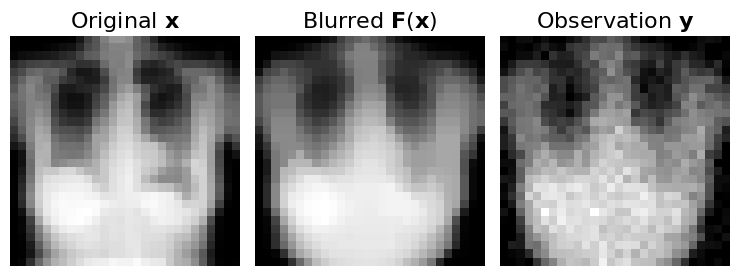

In [6]:
import os
import matplotlib.pyplot as plt

idx = 7181

orig_img = X_raw[idx].cpu()
blur_img = median_blur(X_raw[idx], k=5).squeeze(0).cpu()

noise = torch.randn_like(blur_img) * noiseSigma
obs_img = (blur_img + noise).clamp(0, 1).cpu()

title_fs = 16  # increased title font size

fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.7))
axes[0].imshow(orig_img[0], cmap='gray')
axes[0].set_title(r'Original $\mathbf{x}$', fontsize=title_fs)
axes[0].axis('off')

axes[1].imshow(blur_img, cmap='gray')
axes[1].set_title(r'Blurred $\mathbf{F}(\mathbf{x})$', fontsize=title_fs)
axes[1].axis('off')

axes[2].imshow(obs_img, cmap='gray')
axes[2].set_title(r'Observation $\mathbf{y}$', fontsize=title_fs)
axes[2].axis('off')

plt.tight_layout()
out_dir = f"E2EForward_Nonlinear/Example"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f"{out_dir}/{data_flag}_mapping{idx}_{r}.png", dpi=300)
plt.show()


# Training

### Set up single layer encoder-decoder for comparison

In [68]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)
    def forward(self, x):
        return self.decoder(self.encoder(x))

### Example reconstruction for $r = 25$

Assemble data tensors

In [69]:
X_tensor = X.clone().to(torch.float32)
Y_tensor = Y.clone().to(torch.float32)

Set up and train the encoder-decoder with bottleneck dimension $r=25$

In [ ]:
# --- Autoencoder setup 
batch_size = 128
num_epochs = 350
r = 25

model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop using average per-sample L2 error
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(X.T)
    target  = Y.T

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate average per-sample l2 error
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight
        diffs = A_learned @ X - Y
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()
        train_errors.append(avg_l2_err)

Plot results

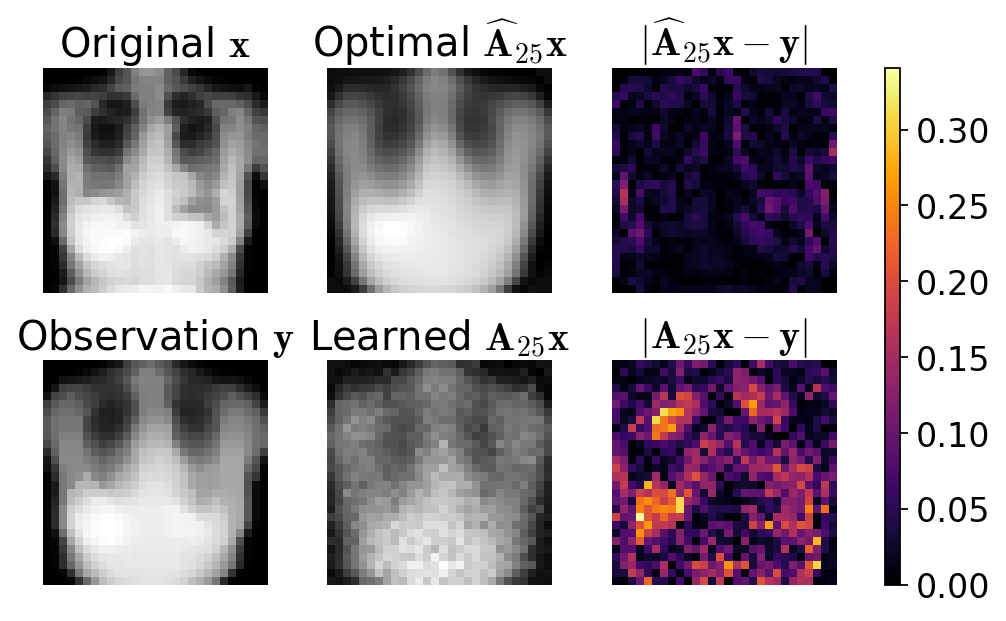

In [71]:
from matplotlib import gridspec

idx = 7181

# original parameters and observations (before and after blurring_)
orig_img  = X_raw[idx].view(28, 28).cpu()
y_img     = Y[:, idx].view(28, 28).cpu()

# optimal reconstruction with rank r = 25 from paper
opt_img   = (A_hat @ X)[:, idx].view(28, 28).cpu()

# leanred reconstruction with rank r = 25 after training
learn_img = (A_learned @ X)[:, idx].view(28, 28).cpu()

err_opt   = torch.abs(opt_img   - y_img)
err_learn = torch.abs(learn_img - y_img)
err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

fig = plt.figure(figsize=(7, 4.2))
gs  = gridspec.GridSpec(
    2, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.20, hspace=0.30
)

# row 0
ax = fig.add_subplot(gs[0, 0])
ax.imshow(orig_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}}\mathbf{{x}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}}\mathbf{{x}} - \mathbf{{y}}|$', pad=4)
ax.axis('off')

# row 1
ax = fig.add_subplot(gs[1, 0])
ax.imshow(y_img, cmap='gray')
ax.set_title(r'Observation $\mathbf{y}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}}\mathbf{{x}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}}\mathbf{{x}} - \mathbf{{y}}|$', pad=4)
ax.axis('off')

cax = fig.add_subplot(gs[:, 3])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

out_dir = f"E2EForward_Nonlinear/Example"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f"{out_dir}/e2eforward_nonlinear_{data_flag}_mapping{idx}_errorcomparison.png", dpi=300)
plt.show()


# Run rank sweep

### Assemble rank sweep helper function (correct version now)

In [ ]:
import os, pickle, torch
from collections import defaultdict
from copy import deepcopy
import matplotlib.pyplot as plt

# where to stash matrices and final plots 
save_root     = "E2EForward_Nonlinear/RankSweep2"
matrices_root = os.path.join(save_root, "Matrices")
tests_root    = os.path.join(save_root, "Pics")
os.makedirs(matrices_root, exist_ok=True)
os.makedirs(tests_root, exist_ok=True)

# helper: run rank sweep on ONE MedMNIST subset 
def run_rank_sweep(data_flag, ranks, train_epochs=350, lr=1e-4):
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    train_ds = DataClass(split='train', download=True)

    numSamples = len(train_ds)
    X_raw = _get_tensor(train_ds, numSamples)
    dim = X_raw[0].numel()

    X = X_raw.view(numSamples, -1).T
    gammaX = (1 / numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
    L_X = torch.linalg.cholesky(gammaX)

    # nonlinear forward operator: median blur
    Y_list = [median_blur(X_raw[i], k=5).view(-1) for i in range(numSamples)]
    Y = torch.stack(Y_list, dim=1).to(device)

    # additive noise
    noiseSigma = 0.05
    E = torch.randn_like(Y) * noiseSigma
    Y_noisy = Y + E

    # right singular vectors of X (V_X)
    U_X, S_X, Vh_X = torch.linalg.svd(X, full_matrices=False)
    V_X = Vh_X.T

    theory_err, learned_err = [], []

    ds_dir = os.path.join(matrices_root, data_flag)
    os.makedirs(ds_dir, exist_ok=True)

    for r in ranks:
        if r % 100 == 0:
            print(f"On Rank {r}")

        V_X_r = V_X[:, :r]

        # memory-safe projection: (Y V_X_r) V_X_r^T
        YV = Y_noisy @ V_X_r
        Y_proj = YV @ V_X_r.T

        # best rank-r approximation of Y_proj
        U, S, Vh = torch.linalg.svd(Y_proj, full_matrices=False)
        U_r, S_r, Vh_r = U[:, :r], S[:r], Vh[:r, :]
        Y_proj_r = U_r @ torch.diag(S_r) @ Vh_r

        # pseudoinverse of X
        X_dag = torch.linalg.pinv(X)

        # optimal empirical mapping
        A_hat = Y_proj_r @ X_dag

        # evaluation of optimal mapping
        diffs_opt = A_hat @ X - Y_noisy
        avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
        theory_err.append(avg_l2_opt)

        # train linear AE on (X → Y_noisy)
        ae = LinearAutoencoder(dim, r).to(device)
        opt = optim.Adam(ae.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for _ in range(train_epochs):
            opt.zero_grad()
            out = ae(X.T)
            loss = criterion(out, Y_noisy.T)
            loss.backward()
            opt.step()

        # learned linear map
        with torch.no_grad():
            W_enc = ae.encoder.weight.detach().cpu()
            W_dec = ae.decoder.weight.detach().cpu()
            A_learn = (W_dec @ W_enc).to(device)

            diffs_learn = A_learn @ X - Y_noisy
            avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
        learned_err.append(avg_l2_learn)

        # save matrices
        dump_path = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        with open(dump_path, "wb") as f:
            pickle.dump(
                {
                    "optimalMatrix": A_hat.cpu(),
                    "encoderWeight": W_enc,
                    "decoderWeight": W_dec,
                    "avgL2Optimal": avg_l2_opt,
                    "avgL2Learned": avg_l2_learn,
                },
                f,
                protocol=pickle.HIGHEST_PROTOCOL,
            )

    return theory_err, learned_err



### Run rank sweeps across the four different datasets for $r \in \{25, 50, \dots, 775\}$



In [73]:
# run all requested datasets
datasets  = ['tissuemnist', 'chestmnist', 'organamnist', 'retinamnist']
#datasets  = ['retinamnist']
ranks     = list(range(25, 776, 25))
results   = defaultdict(dict)
num_epochs = 200 

for flag in datasets:
    print(f"\n▶ Running rank sweep for {flag} …")
    th, le = run_rank_sweep(flag, ranks, train_epochs=num_epochs)
    results[flag]['theory']  = th
    results[flag]['learned'] = le


▶ Running rank sweep for tissuemnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\tissuemnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for chestmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for retinamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700


### Plot results

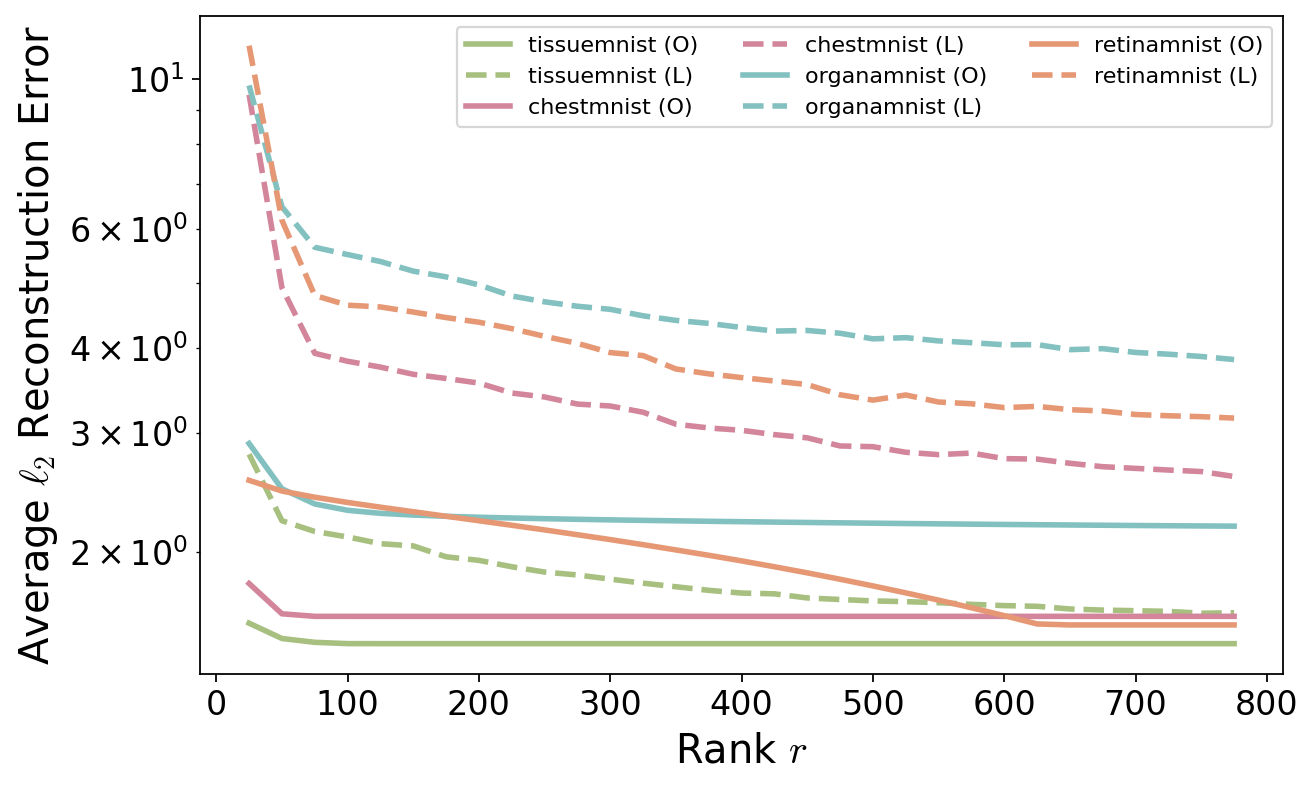

In [ ]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

# Traditional Matplotlib font + high-definition DPI
mpl.rcParams.update({
    "text.usetex": False,          # disable LaTeX
    "font.family": "sans-serif",   # Matplotlib default
    "savefig.dpi": 300,            # HD output
    "figure.dpi": 160,             # HD display in notebook
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 10,
    "figure.titlesize": 20,
})

# Directory containing saved sweep results
base_dir = "E2EForward_Nonlinear/RankSweep2/Matrices"

# Ranks used in sweep
ranks = list(range(25, 776, 25))

# Load results into dictionary
results = {flag: {"theory": [], "learned": []} for flag in datasets}

for flag in datasets:
    ds_dir = os.path.join(base_dir, flag)
    for r in ranks:
        fpath = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"Missing file {fpath}")
        with open(fpath, "rb") as f:
            obj = pickle.load(f)
        results[flag]["theory"].append(obj["avgL2Optimal"])
        results[flag]["learned"].append(obj["avgL2Learned"])

# Plotting configuration
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
lw = 2.5
ms = 4
short_label = {'theory': 'O', 'learned': 'L'}

# Create figure
plt.figure(figsize=(8.5, 5.2), dpi=160)

# Plot each dataset and curve type
for i, flag in enumerate(datasets):
    col = ef_pastel[i % len(ef_pastel)]
    for kind in ("theory", "learned"):
        plt.plot(
            ranks,
            results[flag][kind],
            line_styles[kind],
            color=col,
            lw=lw,
            ms=ms,
            label=f"{flag} ({short_label[kind]})",
        )

# Axis labeling and formatting
plt.xlabel("Rank $r$")
plt.ylabel("Average $\\ell_2$ Reconstruction Error")
plt.yscale("log")
plt.legend(ncol=3)
plt.tight_layout()
plt.savefig("E2EForward_Nonlinear/RankSweep2/Pics/e2eforward_nonlinear_ranksweep_200ep.png",
            dpi=300, bbox_inches='tight')
plt.show()